In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier

from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder, RareLabelCategoricalEncoder, MeanCategoricalEncoder
from feature_engine.outlier_removers import Winsorizer
from feature_engine.discretisers import EqualWidthDiscretiser
from feature_engine.categorical_encoders import WoERatioCategoricalEncoder
from feature_engine import variable_transformers as vt
import scipy.stats as stats


In [2]:
df_train = pd.read_csv('./train.csv')
print(df_train.shape)
df_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_test = pd.read_csv('./test.csv')
print(df_test.shape)
df_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Remove columns with 50% missing

In [4]:
print('Remove:', [df_train.columns[df_train.isnull().mean() > 0.5]])
df_train = df_train[df_train.columns[df_train.isnull().mean() < 0.5]]
print(df_train.shape)
df_train.head()

Remove: [Index(['Cabin'], dtype='object')]
(891, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [5]:
df_test = df_test.drop(columns=['Cabin'],axis=1)
df_test.shape

(418, 10)

### Clean data

In [6]:
for df in [df_train, df_test]:
    df['FamilySize'] = df ['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 1
    df['IsAlone'].loc[df['FamilySize'] > 1] = 0
    df['Ticket_count'] = df_train.groupby('Ticket')['Ticket'].transform('count')
    #df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

/Users/paulin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
for df in [df_train, df_test]:
    df.drop(columns=['PassengerId', 'Name', 'Ticket'], axis=1,inplace=True)
    print(df.shape)
df_train.head()

(891, 11)
(418, 10)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Ticket_count
0,0,3,male,22.0,1,0,7.2500,S,2,0,1
1,1,1,female,38.0,1,0,71.2833,C,2,0,1
2,1,3,female,26.0,0,0,7.9250,S,1,1,1
3,1,1,female,35.0,1,0,53.1000,S,2,0,2
4,0,3,male,35.0,0,0,8.0500,S,1,1,1


In [9]:
bins = [0, 20, 40, 60, 1000]
labels = ['0-20', '20-40', '40-60', '>60']
for df in [df_train, df_test]:
    df['Age_bin'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)
    df['Age_bin'] = df['Age_bin'].astype('O')
    # df.drop(columns=['Age'], axis=1, inplace=True)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Ticket_count,Age_bin
0,0,3,male,22.0,1,0,7.2500,S,2,0,1,20-40
1,1,1,female,38.0,1,0,71.2833,C,2,0,1,20-40
2,1,3,female,26.0,0,0,7.9250,S,1,1,1,20-40
3,1,1,female,35.0,1,0,53.1000,S,2,0,2,20-40
4,0,3,male,35.0,0,0,8.0500,S,1,1,1,20-40


## Modeling Pre-processing

### Separate types of data

In [10]:
def separate_data(data):
    print(data.shape)
    discrete = [var for var in data.columns if data[var].dtype!='O' and var!='id' and data[var].nunique()<10]
    continuous = [var for var in data.columns if data[var].dtype!='O' and var!='id' and var not in discrete]

    # categorical
    categorical = [var for var in data.columns if data[var].dtype=='O'] # and var not in mixed]

    print('{} discrete variables'.format(len(discrete)))
    print('{} continuous variables'.format(len(continuous)))
    print('{} categorical variables'.format(len(categorical)))
    # print('{} mixed variables'.format(len(mixed)))
    
    assert(data.shape[1]==len(discrete) + len(continuous) + len(categorical))
    return discrete, continuous, categorical

In [11]:
discrete, continuous, categorical = separate_data(df_train)

(891, 12)
7 discrete variables
2 continuous variables
3 categorical variables


### Inspect missing values

In [12]:
# discrete
DATA = df_train
for var in discrete:
    print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

Survived sum: 0 , mean: 0.000
Pclass sum: 0 , mean: 0.000
SibSp sum: 0 , mean: 0.000
Parch sum: 0 , mean: 0.000
FamilySize sum: 0 , mean: 0.000
IsAlone sum: 0 , mean: 0.000
Ticket_count sum: 0 , mean: 0.000


In [13]:
# continuous
DATA = df_train
for var in continuous:
    print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

Age sum: 177 , mean: 0.199
Fare sum: 0 , mean: 0.000


In [14]:
# categorical
DATA = df_train
for var in categorical:
    print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

Sex sum: 0 , mean: 0.000
Embarked sum: 2 , mean: 0.002
Age_bin sum: 177 , mean: 0.199


### Inspect distributions

In [15]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

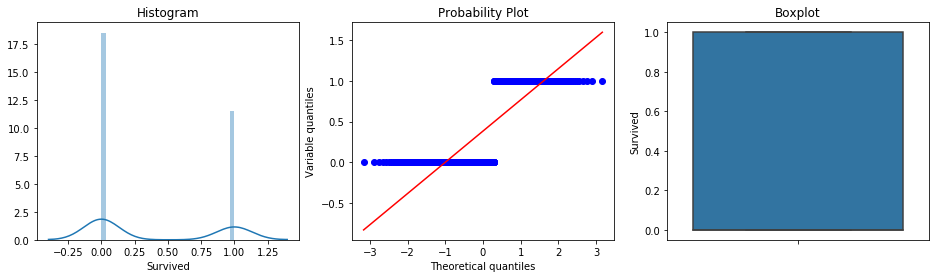

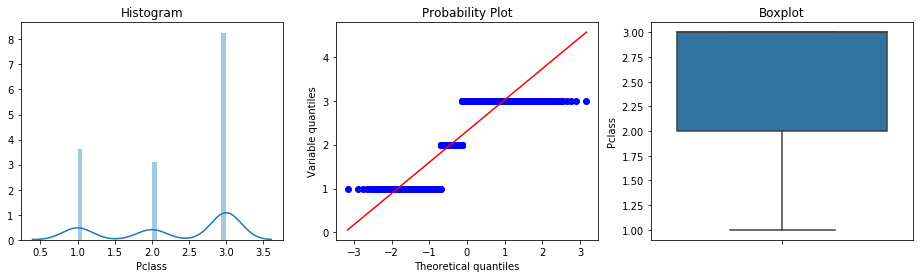

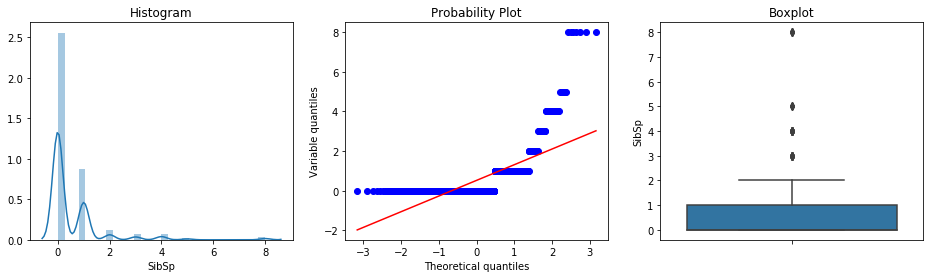

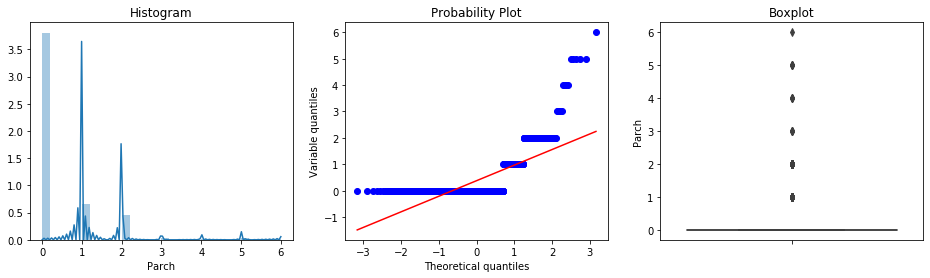

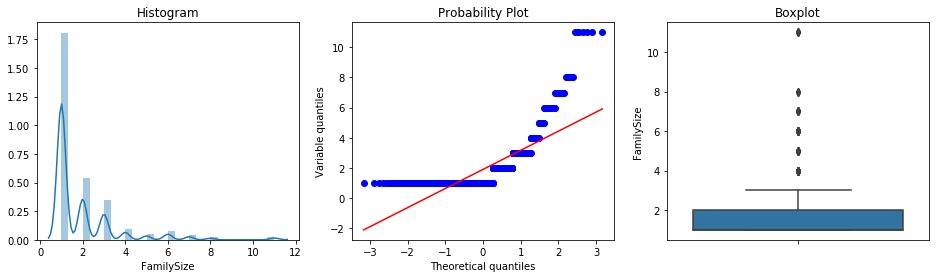

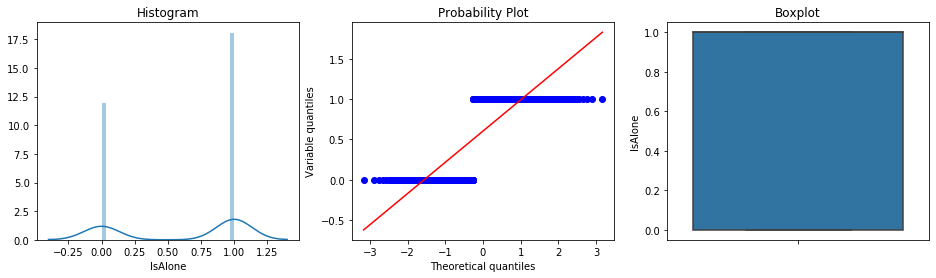

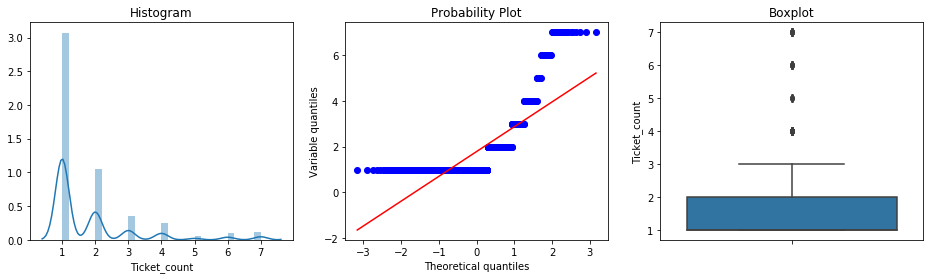

In [16]:
for var in discrete:
    diagnostic_plots(df_train, var)

/Users/paulin/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/paulin/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/paulin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/paulin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


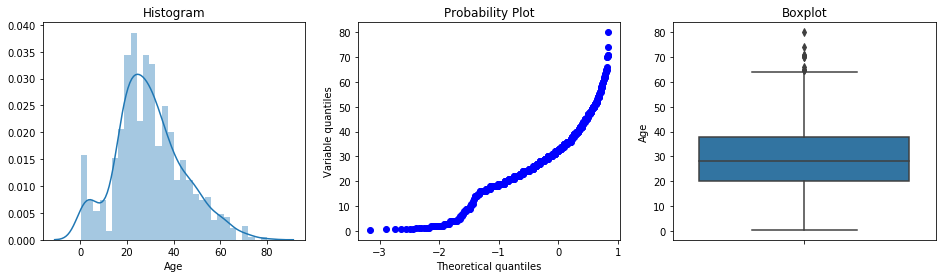

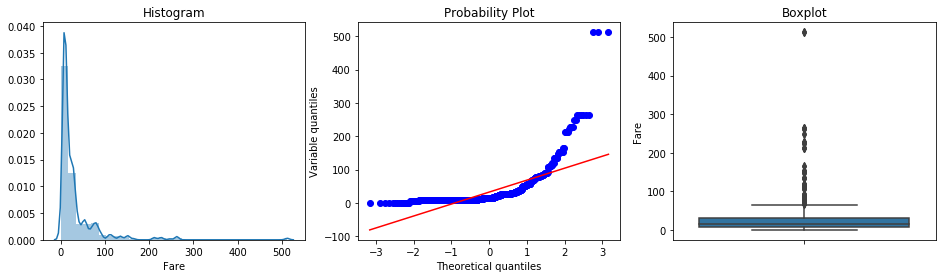

In [17]:
for var in continuous:
    diagnostic_plots(df_train, var)

## Modeling

In [21]:
discrete.remove('Survived')

In [22]:
# df_train = df_train_tf

In [23]:
DATA = df_train
[var for var in DATA.columns if DATA[var].isnull().sum()!=0]

['Age', 'Embarked', 'Age_bin']

In [24]:
X = df_train.drop(columns=['Survived'])
Y = df_train['Survived']

In [25]:
# Let's separate into train and test set

x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=42)
x_train.shape, x_test.shape

((712, 11), (179, 11))

In [26]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Ticket_count,Age_bin
0,0,3,male,22.0,1,0,7.2500,S,2,0,1,20-40
1,1,1,female,38.0,1,0,71.2833,C,2,0,1,20-40
2,1,3,female,26.0,0,0,7.9250,S,1,1,1,20-40
3,1,1,female,35.0,1,0,53.1000,S,2,0,2,20-40
4,0,3,male,35.0,0,0,8.0500,S,1,1,1,20-40


In [27]:
x_train_backup = x_train.copy()
x_test_backup = x_test.copy()

In [28]:
x_train = x_train_backup.copy()
x_test = x_test_backup.copy()

In [29]:
pipe = Pipeline([
#     ('ws', Winsorizer(distribution='skewed', tail='both', fold=1.5, 
#                       variables=discrete_listing+continuous_listing)),
    

    ('nani', mdi.AddNaNBinaryImputer()),
    ('ani', mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['Age'])),
#     ('mmi', mdi.MeanMedianImputer(imputation_method='median',
#                                             variables=['Age'])),
     ('cvi', mdi.CategoricalVariableImputer(variables=['Embarked', 'Age_bin'])),
#     ('ewd', EqualWidthDiscretiser(bins=13, variables = ['Fare'])),
    
#     ('rle', RareLabelCategoricalEncoder(tol=0.005, n_categories=4,
#                                         variables=['Title'])),
    ('oce', OrdinalCategoricalEncoder(encoding_method='ordered', #variables=['Sex', 'Embarked'])),
                                      variables=['Sex', 'Embarked', 'Age_bin'])),
    
#     ('mce', MeanCategoricalEncoder(variables=categorical_listing)),
#     ('ws', Winsorizer(distribution='skewed', tail='both', fold=1.5, 
#                       variables=discrete_listing+continuous_listing)),
    #('sts', StandardScaler()),
#     ('mms', MinMaxScaler()),
    
    #('rf', RandomForestClassifier(random_state=0))
])

pipe.fit(x_train, y_train)
x_train = pipe.transform(x_train)
x_test = pipe.transform(x_test)

In [30]:
print('x_train missing:',[var for var in x_train.columns if x_train[var].isnull().sum()!=0])
print('x_test missing:',[var for var in x_test.columns if x_test[var].isnull().sum()!=0])

x_train missing: []
x_test missing: []


In [31]:
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Ticket_count,...,Sex_na,Age_na,SibSp_na,Parch_na,Fare_na,Embarked_na,FamilySize_na,IsAlone_na,Ticket_count_na,Age_bin_na
331,1,0,45.5,0,0,28.5000,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
733,2,0,23.0,0,0,13.0000,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
382,3,0,32.0,0,0,7.9250,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
704,3,0,26.0,1,0,7.8542,0,2,0,1,...,0,0,0,0,0,0,0,0,0,0
813,3,1,6.0,4,2,31.2750,0,7,0,7,...,0,0,0,0,0,0,0,0,0,0


In [32]:
x_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'FamilySize', 'IsAlone', 'Ticket_count', 'Age_bin', 'Pclass_na',
       'Sex_na', 'Age_na', 'SibSp_na', 'Parch_na', 'Fare_na', 'Embarked_na',
       'FamilySize_na', 'IsAlone_na', 'Ticket_count_na', 'Age_bin_na'],
      dtype='object')

### Various models

In [33]:
classifiers = [
#     LogisticRegression(),
#     Perceptron(),
#     LinearSVC(),
#     SVC(),
#     SGDClassifier(),
#     GaussianNB(),
#     DecisionTreeClassifier(),
#     NuSVC(probability=True),
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LGBMClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier()
    ]

acc_trains, acc_tests, f1_trains, f1_tests, names = [], [], [], [], []
for classifier in classifiers:
    classifier.fit(x_train, y_train)   
    x_train_preds = classifier.predict(x_train)
    x_test_preds = classifier.predict(x_test)
    names.append(classifier.__class__.__name__)
    acc_train = accuracy_score(y_train, x_train_preds)
    acc_test = accuracy_score(y_test, x_test_preds)
    acc_trains.append(acc_train) 
    acc_tests.append(acc_test) 
    f1_train = metrics.f1_score(y_train, x_train_preds)
    f1_test = metrics.f1_score(y_test, x_test_preds)
    f1_trains.append(f1_train)
    f1_tests.append(f1_test)

In [34]:
models = pd.DataFrame({
    'Model': names,
    'Train accuracy': acc_trains,
    'Test accuracy': acc_tests,
    'Train F1': f1_trains,
    'Test F1': f1_tests})
models.sort_values(by=['Test accuracy', 'Test F1'], ascending=False)

,Model,Train accuracy,Test accuracy,Train F1,Test F1
3,LGBMClassifier,0.955056,0.832402,0.937984,0.788732
4,ExtraTreesClassifier,0.980337,0.826816,0.973282,0.783217
1,AdaBoostClassifier,0.842697,0.804469,0.782946,0.761905
5,BaggingClassifier,0.957865,0.804469,0.942748,0.758621
0,RandomForestClassifier,0.980337,0.804469,0.973585,0.751773
2,GradientBoostingClassifier,0.900281,0.798883,0.856566,0.742857


### Neural Network

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [36]:
nn = Sequential([
    Dense(units=64, input_dim=22, activation='relu'),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dropout(0.3),
    Dense(units=256, activation='relu'),
    Dropout(0.4),
    Dense(units=512, activation='relu'),
    Dropout(0.5),
    Dense(units=256, activation='relu'),
    Dropout(0.4),
    Dense(units=128, activation='relu'),
    Dropout(0.3),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid'),
])

print(nn.summary())

nn.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(x_train, y_train, batch_size=64, epochs=1000, validation_data=[x_test,y_test])
print(nn.evaluate(x_test,y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1472      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

Epoch 41/1000
712/712 [==============================] - 0s 71us/step - loss: 0.6228 - accuracy: 0.6728 - val_loss: 0.5888 - val_accuracy: 0.6592
Epoch 42/1000
712/712 [==============================] - 0s 74us/step - loss: 0.5903 - accuracy: 0.6756 - val_loss: 0.5732 - val_accuracy: 0.6704
Epoch 43/1000
712/712 [==============================] - 0s 76us/step - loss: 0.6046 - accuracy: 0.6770 - val_loss: 0.5615 - val_accuracy: 0.6648
Epoch 44/1000
712/712 [==============================] - 0s 71us/step - loss: 0.5710 - accuracy: 0.6826 - val_loss: 0.5538 - val_accuracy: 0.6816
Epoch 45/1000
712/712 [==============================] - 0s 72us/step - loss: 0.5872 - accuracy: 0.6671 - val_loss: 0.5441 - val_accuracy: 0.6760
Epoch 46/1000
712/712 [==============================] - 0s 76us/step - loss: 0.5845 - accuracy: 0.6910 - val_loss: 0.5405 - val_accuracy: 0.7039
Epoch 47/1000
712/712 [==============================] - 0s 72us/step - loss: 0.5864 - accuracy: 0.6742 - val_loss: 0.5568 -

712/712 [==============================] - 0s 70us/step - loss: 0.4944 - accuracy: 0.7781 - val_loss: 0.4788 - val_accuracy: 0.7933
Epoch 98/1000
712/712 [==============================] - 0s 77us/step - loss: 0.4773 - accuracy: 0.8090 - val_loss: 0.4846 - val_accuracy: 0.7933
Epoch 99/1000
712/712 [==============================] - 0s 82us/step - loss: 0.4891 - accuracy: 0.7851 - val_loss: 0.4823 - val_accuracy: 0.7933
Epoch 100/1000
712/712 [==============================] - 0s 81us/step - loss: 0.4673 - accuracy: 0.7921 - val_loss: 0.4669 - val_accuracy: 0.7877
Epoch 101/1000
712/712 [==============================] - 0s 80us/step - loss: 0.4630 - accuracy: 0.7949 - val_loss: 0.4889 - val_accuracy: 0.7933
Epoch 102/1000
712/712 [==============================] - 0s 74us/step - loss: 0.4830 - accuracy: 0.7907 - val_loss: 0.4865 - val_accuracy: 0.7933
Epoch 103/1000
712/712 [==============================] - 0s 73us/step - loss: 0.4905 - accuracy: 0.7921 - val_loss: 0.4890 - val_accur

Epoch 153/1000
712/712 [==============================] - 0s 71us/step - loss: 0.3952 - accuracy: 0.8441 - val_loss: 0.4750 - val_accuracy: 0.8045
Epoch 154/1000
712/712 [==============================] - 0s 74us/step - loss: 0.4224 - accuracy: 0.8258 - val_loss: 0.4841 - val_accuracy: 0.7933
Epoch 155/1000
712/712 [==============================] - 0s 81us/step - loss: 0.4254 - accuracy: 0.8244 - val_loss: 0.4991 - val_accuracy: 0.7821
Epoch 156/1000
712/712 [==============================] - 0s 70us/step - loss: 0.4169 - accuracy: 0.8202 - val_loss: 0.4729 - val_accuracy: 0.8101
Epoch 157/1000
712/712 [==============================] - 0s 71us/step - loss: 0.3990 - accuracy: 0.8385 - val_loss: 0.4625 - val_accuracy: 0.8156
Epoch 158/1000
712/712 [==============================] - 0s 71us/step - loss: 0.4239 - accuracy: 0.8287 - val_loss: 0.4677 - val_accuracy: 0.7989
Epoch 159/1000
712/712 [==============================] - 0s 73us/step - loss: 0.4079 - accuracy: 0.8244 - val_loss: 0

Epoch 209/1000
712/712 [==============================] - 0s 79us/step - loss: 0.3788 - accuracy: 0.8427 - val_loss: 0.4579 - val_accuracy: 0.8101
Epoch 210/1000
712/712 [==============================] - 0s 84us/step - loss: 0.3828 - accuracy: 0.8441 - val_loss: 0.4638 - val_accuracy: 0.8101
Epoch 211/1000
712/712 [==============================] - 0s 84us/step - loss: 0.3736 - accuracy: 0.8455 - val_loss: 0.4470 - val_accuracy: 0.8212
Epoch 212/1000
712/712 [==============================] - 0s 85us/step - loss: 0.3741 - accuracy: 0.8511 - val_loss: 0.4558 - val_accuracy: 0.8156
Epoch 213/1000
712/712 [==============================] - 0s 84us/step - loss: 0.3911 - accuracy: 0.8427 - val_loss: 0.4637 - val_accuracy: 0.7989
Epoch 214/1000
712/712 [==============================] - 0s 77us/step - loss: 0.3616 - accuracy: 0.8483 - val_loss: 0.4716 - val_accuracy: 0.8045
Epoch 215/1000
712/712 [==============================] - 0s 80us/step - loss: 0.3761 - accuracy: 0.8413 - val_loss: 0

Epoch 265/1000
712/712 [==============================] - 0s 83us/step - loss: 0.3649 - accuracy: 0.8483 - val_loss: 0.4982 - val_accuracy: 0.8156
Epoch 266/1000
712/712 [==============================] - 0s 84us/step - loss: 0.3405 - accuracy: 0.8624 - val_loss: 0.5091 - val_accuracy: 0.8156
Epoch 267/1000
712/712 [==============================] - 0s 82us/step - loss: 0.3349 - accuracy: 0.8610 - val_loss: 0.5406 - val_accuracy: 0.8101
Epoch 268/1000
712/712 [==============================] - 0s 80us/step - loss: 0.3383 - accuracy: 0.8638 - val_loss: 0.5255 - val_accuracy: 0.7933
Epoch 269/1000
712/712 [==============================] - 0s 85us/step - loss: 0.3631 - accuracy: 0.8483 - val_loss: 0.5205 - val_accuracy: 0.8045
Epoch 270/1000
712/712 [==============================] - 0s 82us/step - loss: 0.3734 - accuracy: 0.8497 - val_loss: 0.4650 - val_accuracy: 0.8324
Epoch 271/1000
712/712 [==============================] - 0s 81us/step - loss: 0.3628 - accuracy: 0.8511 - val_loss: 0

Epoch 321/1000
712/712 [==============================] - 0s 72us/step - loss: 0.3599 - accuracy: 0.8483 - val_loss: 0.5084 - val_accuracy: 0.8156
Epoch 322/1000
712/712 [==============================] - 0s 70us/step - loss: 0.3465 - accuracy: 0.8301 - val_loss: 0.5632 - val_accuracy: 0.7989
Epoch 323/1000
712/712 [==============================] - 0s 71us/step - loss: 0.3564 - accuracy: 0.8539 - val_loss: 0.5784 - val_accuracy: 0.7877
Epoch 324/1000
712/712 [==============================] - 0s 71us/step - loss: 0.3411 - accuracy: 0.8567 - val_loss: 0.5840 - val_accuracy: 0.8045
Epoch 325/1000
712/712 [==============================] - 0s 70us/step - loss: 0.3419 - accuracy: 0.8469 - val_loss: 0.5959 - val_accuracy: 0.7989
Epoch 326/1000
712/712 [==============================] - 0s 72us/step - loss: 0.3558 - accuracy: 0.8553 - val_loss: 0.5768 - val_accuracy: 0.7933
Epoch 327/1000
712/712 [==============================] - 0s 71us/step - loss: 0.3622 - accuracy: 0.8441 - val_loss: 0

Epoch 377/1000
712/712 [==============================] - 0s 86us/step - loss: 0.3387 - accuracy: 0.8427 - val_loss: 0.5768 - val_accuracy: 0.7877
Epoch 378/1000
712/712 [==============================] - 0s 79us/step - loss: 0.3326 - accuracy: 0.8581 - val_loss: 0.5687 - val_accuracy: 0.8156
Epoch 379/1000
712/712 [==============================] - 0s 75us/step - loss: 0.3169 - accuracy: 0.8666 - val_loss: 0.5672 - val_accuracy: 0.8156
Epoch 380/1000
712/712 [==============================] - 0s 76us/step - loss: 0.3404 - accuracy: 0.8525 - val_loss: 0.5620 - val_accuracy: 0.8212
Epoch 381/1000
712/712 [==============================] - 0s 75us/step - loss: 0.3356 - accuracy: 0.8497 - val_loss: 0.5594 - val_accuracy: 0.8324
Epoch 382/1000
712/712 [==============================] - 0s 78us/step - loss: 0.3436 - accuracy: 0.8567 - val_loss: 0.5615 - val_accuracy: 0.8156
Epoch 383/1000
712/712 [==============================] - 0s 78us/step - loss: 0.3231 - accuracy: 0.8694 - val_loss: 0

Epoch 433/1000
712/712 [==============================] - 0s 81us/step - loss: 0.3249 - accuracy: 0.8553 - val_loss: 0.6450 - val_accuracy: 0.8156
Epoch 434/1000
712/712 [==============================] - 0s 79us/step - loss: 0.3381 - accuracy: 0.8581 - val_loss: 0.6094 - val_accuracy: 0.8156
Epoch 435/1000
712/712 [==============================] - 0s 78us/step - loss: 0.3252 - accuracy: 0.8624 - val_loss: 0.5978 - val_accuracy: 0.8156
Epoch 436/1000
712/712 [==============================] - 0s 77us/step - loss: 0.3180 - accuracy: 0.8624 - val_loss: 0.6992 - val_accuracy: 0.8156
Epoch 437/1000
712/712 [==============================] - 0s 77us/step - loss: 0.3221 - accuracy: 0.8610 - val_loss: 0.6538 - val_accuracy: 0.8156
Epoch 438/1000
712/712 [==============================] - 0s 83us/step - loss: 0.3313 - accuracy: 0.8511 - val_loss: 0.6890 - val_accuracy: 0.8045
Epoch 439/1000
712/712 [==============================] - 0s 78us/step - loss: 0.3154 - accuracy: 0.8596 - val_loss: 0

Epoch 489/1000
712/712 [==============================] - 0s 80us/step - loss: 0.3068 - accuracy: 0.8652 - val_loss: 0.7343 - val_accuracy: 0.8045
Epoch 490/1000
712/712 [==============================] - 0s 80us/step - loss: 0.2962 - accuracy: 0.8708 - val_loss: 0.7260 - val_accuracy: 0.8156
Epoch 491/1000
712/712 [==============================] - 0s 79us/step - loss: 0.3086 - accuracy: 0.8750 - val_loss: 0.6853 - val_accuracy: 0.8156
Epoch 492/1000
712/712 [==============================] - 0s 78us/step - loss: 0.3111 - accuracy: 0.8736 - val_loss: 0.7228 - val_accuracy: 0.8212
Epoch 493/1000
712/712 [==============================] - 0s 79us/step - loss: 0.3114 - accuracy: 0.8708 - val_loss: 0.7602 - val_accuracy: 0.8156
Epoch 494/1000
712/712 [==============================] - 0s 79us/step - loss: 0.3004 - accuracy: 0.8750 - val_loss: 0.7520 - val_accuracy: 0.8268
Epoch 495/1000
712/712 [==============================] - 0s 78us/step - loss: 0.3015 - accuracy: 0.8722 - val_loss: 0

Epoch 545/1000
712/712 [==============================] - 0s 75us/step - loss: 0.3061 - accuracy: 0.8708 - val_loss: 0.6336 - val_accuracy: 0.8101
Epoch 546/1000
712/712 [==============================] - 0s 74us/step - loss: 0.3333 - accuracy: 0.8553 - val_loss: 0.6435 - val_accuracy: 0.8101
Epoch 547/1000
712/712 [==============================] - 0s 74us/step - loss: 0.3166 - accuracy: 0.8652 - val_loss: 0.6639 - val_accuracy: 0.8045
Epoch 548/1000
712/712 [==============================] - 0s 76us/step - loss: 0.3090 - accuracy: 0.8694 - val_loss: 0.6462 - val_accuracy: 0.8156
Epoch 549/1000
712/712 [==============================] - 0s 74us/step - loss: 0.3079 - accuracy: 0.8624 - val_loss: 0.6921 - val_accuracy: 0.8212
Epoch 550/1000
712/712 [==============================] - 0s 77us/step - loss: 0.3000 - accuracy: 0.8610 - val_loss: 0.7011 - val_accuracy: 0.8268
Epoch 551/1000
712/712 [==============================] - 0s 77us/step - loss: 0.3174 - accuracy: 0.8736 - val_loss: 0

Epoch 601/1000
712/712 [==============================] - 0s 75us/step - loss: 0.3084 - accuracy: 0.8652 - val_loss: 0.7121 - val_accuracy: 0.8101
Epoch 602/1000
712/712 [==============================] - 0s 72us/step - loss: 0.3312 - accuracy: 0.8525 - val_loss: 0.7744 - val_accuracy: 0.8156
Epoch 603/1000
712/712 [==============================] - 0s 73us/step - loss: 0.3170 - accuracy: 0.8610 - val_loss: 0.7794 - val_accuracy: 0.8212
Epoch 604/1000
712/712 [==============================] - 0s 71us/step - loss: 0.3191 - accuracy: 0.8694 - val_loss: 0.6996 - val_accuracy: 0.8324
Epoch 605/1000
712/712 [==============================] - 0s 72us/step - loss: 0.3107 - accuracy: 0.8750 - val_loss: 0.6992 - val_accuracy: 0.8380
Epoch 606/1000
712/712 [==============================] - 0s 75us/step - loss: 0.2990 - accuracy: 0.8722 - val_loss: 0.7562 - val_accuracy: 0.8156
Epoch 607/1000
712/712 [==============================] - 0s 75us/step - loss: 0.2829 - accuracy: 0.8806 - val_loss: 0

Epoch 657/1000
712/712 [==============================] - 0s 83us/step - loss: 0.3222 - accuracy: 0.8708 - val_loss: 0.5982 - val_accuracy: 0.8156
Epoch 658/1000
712/712 [==============================] - 0s 83us/step - loss: 0.3190 - accuracy: 0.8652 - val_loss: 0.5994 - val_accuracy: 0.8436
Epoch 659/1000
712/712 [==============================] - 0s 82us/step - loss: 0.3217 - accuracy: 0.8567 - val_loss: 0.6601 - val_accuracy: 0.8380
Epoch 660/1000
712/712 [==============================] - 0s 86us/step - loss: 0.3127 - accuracy: 0.8638 - val_loss: 0.6862 - val_accuracy: 0.8212
Epoch 661/1000
712/712 [==============================] - 0s 84us/step - loss: 0.2976 - accuracy: 0.8722 - val_loss: 0.7696 - val_accuracy: 0.8212
Epoch 662/1000
712/712 [==============================] - 0s 96us/step - loss: 0.2946 - accuracy: 0.8890 - val_loss: 0.7786 - val_accuracy: 0.8268
Epoch 663/1000
712/712 [==============================] - 0s 93us/step - loss: 0.2930 - accuracy: 0.8708 - val_loss: 0

Epoch 713/1000
712/712 [==============================] - 0s 82us/step - loss: 0.2887 - accuracy: 0.8778 - val_loss: 0.7202 - val_accuracy: 0.8156
Epoch 714/1000
712/712 [==============================] - 0s 78us/step - loss: 0.3099 - accuracy: 0.8680 - val_loss: 0.6732 - val_accuracy: 0.8212
Epoch 715/1000
712/712 [==============================] - 0s 79us/step - loss: 0.2945 - accuracy: 0.8553 - val_loss: 0.7098 - val_accuracy: 0.8156
Epoch 716/1000
712/712 [==============================] - 0s 79us/step - loss: 0.2837 - accuracy: 0.8919 - val_loss: 0.7603 - val_accuracy: 0.8212
Epoch 717/1000
712/712 [==============================] - 0s 73us/step - loss: 0.3000 - accuracy: 0.8792 - val_loss: 0.8643 - val_accuracy: 0.8324
Epoch 718/1000
712/712 [==============================] - 0s 76us/step - loss: 0.3067 - accuracy: 0.8708 - val_loss: 0.8188 - val_accuracy: 0.8324
Epoch 719/1000
712/712 [==============================] - 0s 75us/step - loss: 0.2906 - accuracy: 0.8820 - val_loss: 0

Epoch 769/1000
712/712 [==============================] - 0s 73us/step - loss: 0.2992 - accuracy: 0.8750 - val_loss: 0.7259 - val_accuracy: 0.8380
Epoch 770/1000
712/712 [==============================] - 0s 73us/step - loss: 0.3145 - accuracy: 0.8666 - val_loss: 0.7405 - val_accuracy: 0.8324
Epoch 771/1000
712/712 [==============================] - 0s 74us/step - loss: 0.2957 - accuracy: 0.8708 - val_loss: 0.6863 - val_accuracy: 0.8547
Epoch 772/1000
712/712 [==============================] - 0s 77us/step - loss: 0.2928 - accuracy: 0.8736 - val_loss: 0.7153 - val_accuracy: 0.8436
Epoch 773/1000
712/712 [==============================] - 0s 74us/step - loss: 0.2927 - accuracy: 0.8778 - val_loss: 0.7670 - val_accuracy: 0.8212
Epoch 774/1000
712/712 [==============================] - 0s 74us/step - loss: 0.3290 - accuracy: 0.8778 - val_loss: 0.5899 - val_accuracy: 0.8324
Epoch 775/1000
712/712 [==============================] - 0s 75us/step - loss: 0.3274 - accuracy: 0.8581 - val_loss: 0

Epoch 825/1000
712/712 [==============================] - 0s 79us/step - loss: 0.2927 - accuracy: 0.8806 - val_loss: 0.8242 - val_accuracy: 0.8492
Epoch 826/1000
712/712 [==============================] - 0s 82us/step - loss: 0.2882 - accuracy: 0.8778 - val_loss: 0.8427 - val_accuracy: 0.8380
Epoch 827/1000
712/712 [==============================] - 0s 91us/step - loss: 0.2975 - accuracy: 0.8666 - val_loss: 0.8022 - val_accuracy: 0.8492
Epoch 828/1000
712/712 [==============================] - 0s 87us/step - loss: 0.2874 - accuracy: 0.8820 - val_loss: 0.7318 - val_accuracy: 0.8492
Epoch 829/1000
712/712 [==============================] - 0s 96us/step - loss: 0.3095 - accuracy: 0.8792 - val_loss: 0.7250 - val_accuracy: 0.8492
Epoch 830/1000
712/712 [==============================] - 0s 90us/step - loss: 0.2929 - accuracy: 0.8708 - val_loss: 0.7826 - val_accuracy: 0.8380
Epoch 831/1000
712/712 [==============================] - 0s 85us/step - loss: 0.2742 - accuracy: 0.8820 - val_loss: 0

Epoch 881/1000
712/712 [==============================] - 0s 75us/step - loss: 0.2768 - accuracy: 0.8820 - val_loss: 0.8396 - val_accuracy: 0.8547
Epoch 882/1000
712/712 [==============================] - 0s 75us/step - loss: 0.3295 - accuracy: 0.8694 - val_loss: 0.7378 - val_accuracy: 0.8436
Epoch 883/1000
712/712 [==============================] - 0s 73us/step - loss: 0.3083 - accuracy: 0.8638 - val_loss: 0.6640 - val_accuracy: 0.8492
Epoch 884/1000
712/712 [==============================] - 0s 73us/step - loss: 0.3242 - accuracy: 0.8778 - val_loss: 0.5202 - val_accuracy: 0.8436
Epoch 885/1000
712/712 [==============================] - 0s 73us/step - loss: 0.3042 - accuracy: 0.8694 - val_loss: 0.6345 - val_accuracy: 0.8492
Epoch 886/1000
712/712 [==============================] - 0s 74us/step - loss: 0.2884 - accuracy: 0.8778 - val_loss: 0.8389 - val_accuracy: 0.8547
Epoch 887/1000
712/712 [==============================] - 0s 73us/step - loss: 0.2730 - accuracy: 0.8834 - val_loss: 0

Epoch 937/1000
712/712 [==============================] - 0s 90us/step - loss: 0.3057 - accuracy: 0.8567 - val_loss: 0.7133 - val_accuracy: 0.8212
Epoch 938/1000
712/712 [==============================] - 0s 87us/step - loss: 0.2833 - accuracy: 0.8778 - val_loss: 0.7430 - val_accuracy: 0.8212
Epoch 939/1000
712/712 [==============================] - 0s 84us/step - loss: 0.3137 - accuracy: 0.8694 - val_loss: 0.8001 - val_accuracy: 0.8101
Epoch 940/1000
712/712 [==============================] - 0s 87us/step - loss: 0.2843 - accuracy: 0.8806 - val_loss: 0.7700 - val_accuracy: 0.7989
Epoch 941/1000
712/712 [==============================] - 0s 84us/step - loss: 0.2981 - accuracy: 0.8834 - val_loss: 0.7516 - val_accuracy: 0.8380
Epoch 942/1000
712/712 [==============================] - 0s 87us/step - loss: 0.2967 - accuracy: 0.8708 - val_loss: 0.7061 - val_accuracy: 0.8324
Epoch 943/1000
712/712 [==============================] - 0s 83us/step - loss: 0.2857 - accuracy: 0.8764 - val_loss: 0

Epoch 993/1000
712/712 [==============================] - 0s 80us/step - loss: 0.2621 - accuracy: 0.8848 - val_loss: 0.9640 - val_accuracy: 0.8156
Epoch 994/1000
712/712 [==============================] - 0s 82us/step - loss: 0.2733 - accuracy: 0.8834 - val_loss: 0.9350 - val_accuracy: 0.8268
Epoch 995/1000
712/712 [==============================] - 0s 81us/step - loss: 0.2887 - accuracy: 0.8736 - val_loss: 0.8363 - val_accuracy: 0.8380
Epoch 996/1000
712/712 [==============================] - 0s 84us/step - loss: 0.2687 - accuracy: 0.8778 - val_loss: 0.8895 - val_accuracy: 0.8380
Epoch 997/1000
712/712 [==============================] - 0s 82us/step - loss: 0.2760 - accuracy: 0.8792 - val_loss: 0.9331 - val_accuracy: 0.8380
Epoch 998/1000
712/712 [==============================] - 0s 82us/step - loss: 0.2701 - accuracy: 0.8862 - val_loss: 0.9966 - val_accuracy: 0.8156
Epoch 999/1000
712/712 [==============================] - 0s 82us/step - loss: 0.3359 - accuracy: 0.8624 - val_loss: 0

### Tune the best model

In [37]:
pipe = Pipeline([
    ('model', LGBMClassifier(random_state=0))
])

param_grid = {
    'model__num_leaves': [31,131,231],
    'model__n_estimators':[100,200,300],
}

gscv = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gscv.fit(x_train, y_train)

x_train_preds = gscv.predict_proba(x_train)[:,1]
x_test_preds = gscv.predict_proba(x_test)[:,1]
print('Train roc-auc: %.3f' %(roc_auc_score(y_train, x_train_preds)))
print('Train roc-auc: %.3f' %(roc_auc_score(y_test, x_test_preds)))
x_train_preds = gscv.predict(x_train)
x_test_preds = gscv.predict(x_test)
print('Train accuracy: %.3f' %(accuracy_score(y_train, x_train_preds)))
print('Test accuracy: %.3f' %(accuracy_score(y_test, x_test_preds)))
print('best params:', gscv.best_params_)

Train roc-auc: 0.992
Train roc-auc: 0.886
Train accuracy: 0.955
Test accuracy: 0.832
best params: {'model__n_estimators': 100, 'model__num_leaves': 31}


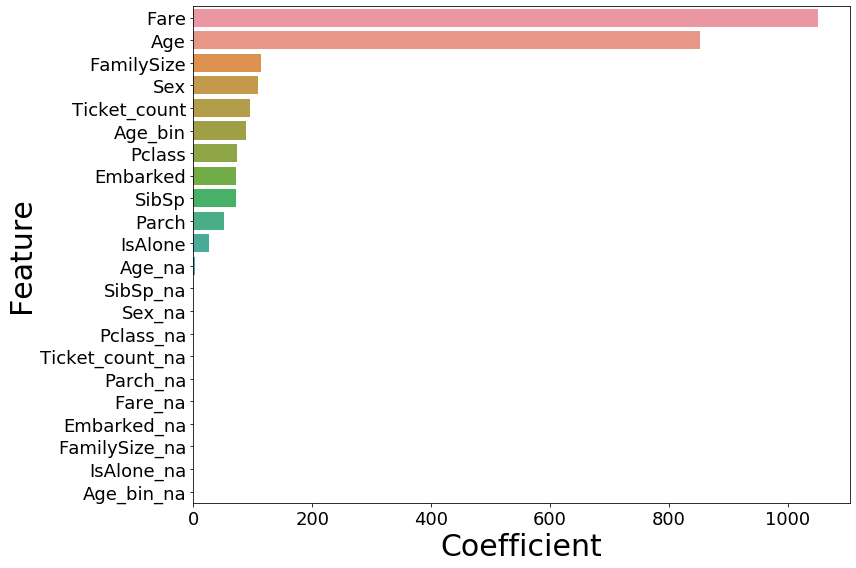

In [38]:
importance = pd.Series(gscv.best_estimator_['model'].feature_importances_)
importance.index =x_train.columns
importance.sort_values(inplace=True, ascending=False)
importance = importance#[:10]

feature_names = list(importance.index)
feature_coeffs = list(importance)
feature_coef_df = pd.DataFrame(list(zip(feature_names, feature_coeffs)), 
                               columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x='Coefficient', y='Feature', data=feature_coef_df.iloc[:len(feature_names)+1], ax=ax)
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
ax.tick_params(labelsize=18)
plt.tight_layout()
#ax.get_figure().savefig(f'./imgs/feature_importance.png')


### Use all data to train

In [39]:
pipe = Pipeline([
#     ('ws', Winsorizer(distribution='skewed', tail='both', fold=1.5, 
#                       variables=discrete_listing+continuous_listing)),
    

    ('nani', mdi.AddNaNBinaryImputer()),
    ('ani', mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['Age'])),
#     ('mmi', mdi.MeanMedianImputer(imputation_method='median',
#                                             variables=['Age'])),
     ('cvi', mdi.CategoricalVariableImputer(variables=['Embarked', 'Age_bin'])),
#     ('ewd', EqualWidthDiscretiser(bins=13, variables = ['Fare'])),
    
#     ('rle', RareLabelCategoricalEncoder(tol=0.005, n_categories=4,
#                                         variables=['Title'])),
    ('oce', OrdinalCategoricalEncoder(encoding_method='ordered', #variables=['Sex', 'Embarked'])),
                                      variables=['Sex', 'Embarked', 'Age_bin'])),
    
#     ('mce', MeanCategoricalEncoder(variables=categorical_listing)),
#     ('ws', Winsorizer(distribution='skewed', tail='both', fold=1.5, 
#                       variables=discrete_listing+continuous_listing)),
    #('sts', StandardScaler()),
#     ('mms', MinMaxScaler()),
    
    #('rf', RandomForestClassifier(random_state=0))
])

pipe.fit(X, Y)
X = pipe.transform(X)
df_test = pipe.transform(df_test)
DATA = X
print('DATA missing:',[var for var in DATA.columns if DATA[var].isnull().sum()!=0])

DATA missing: []


### Balancd data

In [40]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X , Y = sm.fit_resample(X,Y)
pd.Series(Y).value_counts()

1    549
0    549
Name: Survived, dtype: int64

In [41]:
pipe = Pipeline([
    ('model', LGBMClassifier(random_state=0))
])

param_grid = {
    'model__num_leaves': [31],
    'model__n_estimators':[100],
}

gscv = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gscv.fit(X, Y)

X_preds = gscv.predict_proba(X)[:,1]
print('roc-auc: %.3f' %(roc_auc_score(Y, X_preds)))
X_preds = gscv.predict(X)
print('accuracy: %.3f' %(accuracy_score(Y, X_preds)))

roc-auc: 0.992
accuracy: 0.955


In [42]:
test_results = gscv.predict(df_test)
df_test = pd.read_csv('./test.csv')

submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": test_results
    })
submission.to_csv('/Users/paulin/Desktop/submission.csv', index=False)